# AKLT state
The AKLT state is the ground state of the following Hamiltonian

$$H = \frac{1}{2}\sum_{j} \left[\mathbf S_j\cdot \mathbf S_{j+1} + \frac{1}{3}\left(\mathbf S_j\cdot \mathbf S_{j+1}\right)^2 + \frac{2}{3}\right]$$

There is actually an implementation of the AKLT model in the source code, so I will just learn the "correct" way of doing thing

In [9]:
import numpy as np
from tenpy.linalg import np_conserved as npc
from tenpy.networks.site import SpinSite,kron
from tenpy.networks.mps import MPS
from tenpy.models.lattice import Chain
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel
from tenpy.algorithms import dmrg
from tenpy.tools.params import asConfig
import matplotlib.pyplot as plt

In [2]:
site = SpinSite(S=1,conserve='Sz',sort_charge=True)

We need to construct the tensor products
$S_+\otimes S_-$ etc.

Initially $S_+,S_-$ has index structure `p p*`

In [3]:
Sp, Sm, Sz = site.Sp, site.Sm, site.Sz
S_dot_S = 0.5 * (kron(Sp, Sm) + kron(Sm, Sp)) + kron(Sz, Sz)
S_dot_S_square = npc.tensordot(S_dot_S, S_dot_S, [['(p0*.p1*)'], ['(p0.p1)']])
S_dot_S, S_dot_S_square

(<npc.Array shape=(9, 9) labels=['(p0.p1)', '(p0*.p1*)']>,
 <npc.Array shape=(9, 9) labels=['(p0.p1)', '(p0*.p1*)']>)

In [4]:
Sp # Before kronecker product 

<npc.Array shape=(3, 3) labels=['p', 'p*']>

We see that after kroncker product, the two legs are combined and gives indices of form `(p0.p1) (p0*.p1*)`

In [5]:
kron(Sp,Sm) # After kronecker

<npc.Array shape=(9, 9) labels=['(p0.p1)', '(p0*.p1*)']>

We can create terms like $\left(\mathbf S_i \cdot \mathbf S_{i+1}\right)^2$ by contracting indicies using `tensordot` method

In the AKLT model we uses the `NearestNeighborModel`, which implements a NN model in 1D given a two body Hamiltonian $H_{i,i+1}$. The legs signature for the two site Hamiltonian should be `p0, p0*, p1, p1*`. But I am not sure why in the code they are casting it into `p0, p1, p0*, p1*`

```python
H_bond.split_legs().transpose(['p0', 'p1', 'p0*', 'p1*']) # The implementation on Github
```

```python 
H_bond.split_legs().transpose(['p0', 'p0*', 'p1', 'p1*']) # What I would expect following the docs of NNModel
```

## Testing the already implemented AKLT model
To resolve this issue, I will first run the pre-implemented model and see if the ground state actually make sense. The list of things to compare is
1. The overlap with the AKLT ground state
2. Ground state energy 
3. NN total spin (Because in AKLT NN total spin should be zero)
4. Correlation lengths? (Of what)

## Infinite MPS
Consider the transfer matrix $T=\sum_{s}M^s \otimes \left(M^{s}\right)^*$. The MPS matrices are $M^{[n]+1} = \sqrt{\frac{2}{3}} \begin{pmatrix}0&0\\ 1 &0\end{pmatrix}$ $M^{[n]+0} = \sqrt{\frac{1}{3}} \begin{pmatrix}1&0\\ 0 &-1\end{pmatrix}$ $M^{[n]-1} = \sqrt{\frac{2}{3}} \begin{pmatrix}0&-1\\ 0 &0\end{pmatrix}$


Therefore the transfer matrix takes the form 
$T=\left(
\begin{array}{cccc}
 \frac{1}{3} & 0 & 0 & \frac{2}{3} \\
 0 & -\frac{1}{3} & 0 & 0 \\
 0 & 0 & -\frac{1}{3} & 0 \\
 \frac{2}{3} & 0 & 0 & \frac{1}{3} \\
\end{array}
\right)$

The matrix is symmetric, so left and right dominant eigenvector coincide, and the eigensystem of the matrix is $\lambda = 1, -1/3$, corresponding to eigenvectors $(1,0,0,1)$ and $\{(-1,0,0,1),(0,0,1,0),(0,1,0,0)\}$ respectively.

The wavefunction is normalized in thermodynamic limit. To see that, the state when $L\to \infty$ is given by
$$\lim_{L\to\infty} T^L = \ket{\omega}\bra{\omega}$$
where $\ket{\omega} = \frac{1}{\sqrt 2}\sum_{i=0}^1 \ket{ii}$ is the properly normalized generalized bell state. This is normalized if we pick the dangling hands to be $\ket{\omega}$ 
<div>
    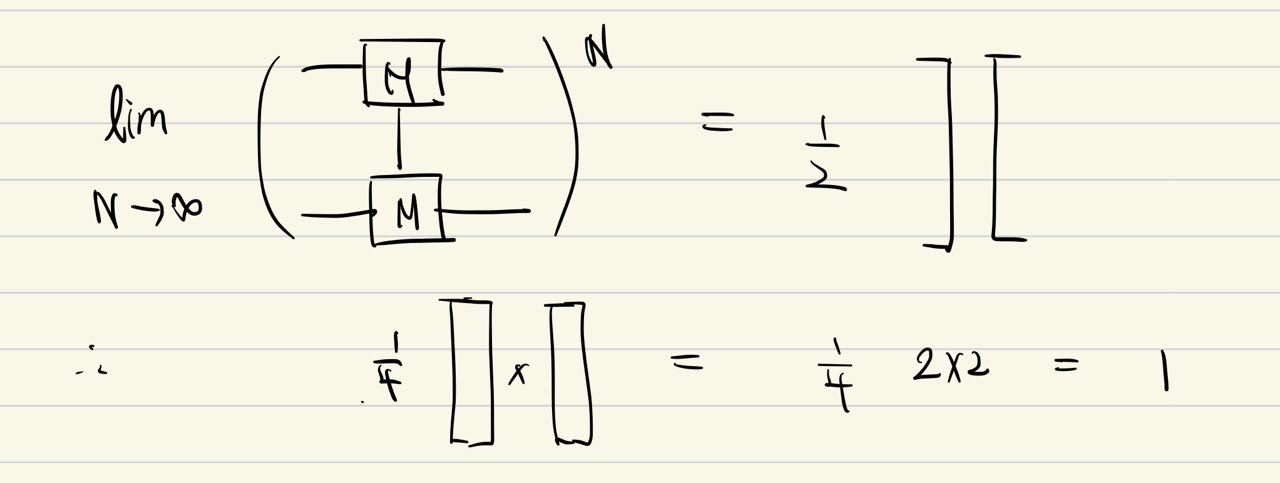
</div>
The spin-spin correlation function can be calculated by the diagram (for details, consult the mathematica code):
<div>
    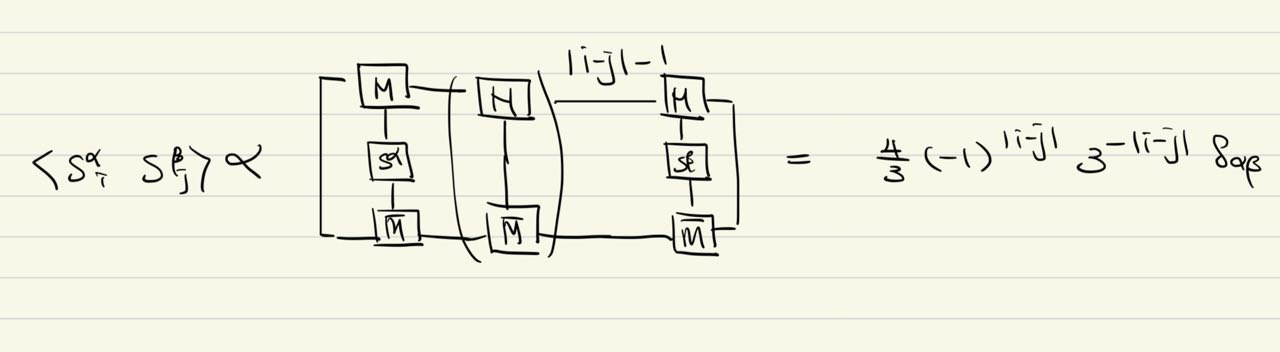
</div>


In [6]:
from tenpy.models.aklt import AKLTChain
model_params = dict(bc_MPS='infinite')
model = AKLTChain(model_params)

In [7]:
print('AKLT model: ',model.psi_AKLT().correlation_length(),'Theoretical',1/np.log(3))

AKLT model:  0.9102392266268371 Theoretical 0.9102392266268373


Text(0, 0.5, 'Spin-spin correlation $\\langle S^z_i S^z_j\\rangle$')

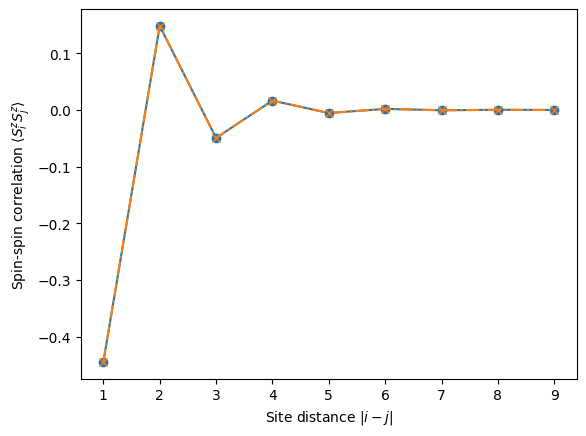

In [10]:
siteIdc = np.arange(1,10)
plt.plot(siteIdc,(model.psi_AKLT().correlation_function('Sz','Sz',sites1=1,sites2=10))[0,1:],marker='o')
plt.plot(siteIdc,(4/3)*((-1)**siteIdc)*((1/3)**siteIdc),marker='x',ls='-.')
plt.xlabel(r'Site distance $|i-j|$')
plt.ylabel(r'Spin-spin correlation $\langle S^z_i S^z_j\rangle$')

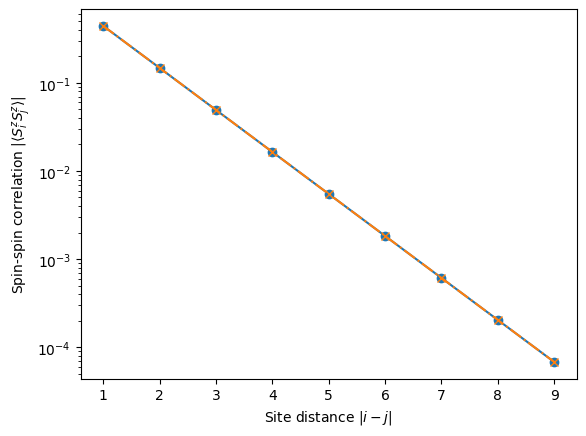

In [11]:
siteIdc = np.arange(1,10)
plt.plot(siteIdc,np.abs((model.psi_AKLT().correlation_function('Sz','Sz',sites1=1,sites2=10)))[0,1:],marker='o')
plt.plot(siteIdc,np.abs((4/3)*((-1)**siteIdc)*((1/3)**siteIdc)),marker='x',ls='-.')
plt.xlabel(r'Site distance $|i-j|$')
plt.ylabel(r'Spin-spin correlation $|\langle S^z_i S^z_j\rangle|$')
plt.yscale('log')

### String order parameter
The AKLT state has a hidden string order, which can be probed by the string order parameter
$$\Pi^\alpha_{i,i+r} = S^{\alpha}_i e^{i\pi \sum_{j=i}^{i+r-1} S^\alpha_j} S^\alpha_{i+r}$$

Question: Is it $i$ or $i+1$

Answer: It does not matter, because the starting spin must be 1 or -1. In other case that will give you a negative sign due to $\exp(\pm i\pi)= -1$

Question: Why is it constant? I thought the string only gives a phase, how does it work?

In [25]:
def exp_string_op(state,sitelim):
    site = SpinSite(S=1)
    expSz = npc.expm(np.pi*1.j*site.Sz)
    return state.correlation_function('Sz','Sz',opstr=expSz,str_on_first=True,sites1=1,sites2=sitelim)

In [26]:
exp_string_op(model.psi_AKLT(),20)

array([[0.66666667, 0.44444444, 0.44444444, 0.44444444, 0.44444444,
        0.44444444, 0.44444444, 0.44444444, 0.44444444, 0.44444444,
        0.44444444, 0.44444444, 0.44444444, 0.44444444, 0.44444444,
        0.44444444, 0.44444444, 0.44444444, 0.44444444, 0.44444444]])

## Finite AKLT chain

In [27]:
from tenpy.linalg.np_conserved import tensordot

Text(0.5, 0, 'Site difference $|i-j|$')

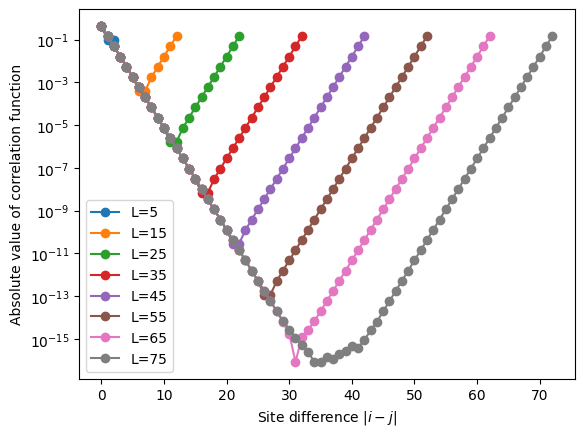

In [29]:
L = np.arange(5,80,10)
for l in L:
    model_params = dict(L=l,bc_MPS='finite')
    model = AKLTChain(model_params)
    siteIdc = np.arange(1,l)
    site1,site2 = int(1),int(l-1)
    #print(site1,site2)
    plt.plot(np.abs(model.psi_AKLT().correlation_function('Sz','Sz',sites1=site1, sites2=site2)[0,1:]),marker='o',label=f'L={l}')
plt.yscale('log')
plt.legend()
plt.ylabel('Absolute value of correlation function')
plt.xlabel(r'Site difference $|i-j|$')

Expectation value of $S_z$? What does it goes to zero

In [31]:
model = AKLTChain(dict(L=20,bc_MPS='finite'))
model.psi_AKLT().expectation_value('Sz')

array([ 6.66666667e-01, -2.22222224e-01,  7.40740792e-02, -2.46913735e-02,
        8.23049913e-03, -2.74362361e-03,  9.14912892e-04, -3.06086031e-04,
        1.05373880e-04, -4.51602341e-05,  4.51602341e-05, -1.05373880e-04,
        3.06086031e-04, -9.14912892e-04,  2.74362361e-03, -8.23049913e-03,
        2.46913735e-02, -7.40740792e-02,  2.22222224e-01, -6.66666667e-01])

In [111]:
Sp = SpinSite(S=1).Sp
Sm = SpinSite(S=1).Sm
Sz = SpinSite(S=1).Sz
Sp,Sm,Sz

(<npc.Array shape=(3, 3) labels=['p', 'p*']>,
 <npc.Array shape=(3, 3) labels=['p', 'p*']>,
 <npc.Array shape=(3, 3) labels=['p', 'p*']>)

In [34]:
exp_string_op(model.psi_AKLT(),20)

array([[0.66666667, 0.44444445, 0.44444445, 0.44444445, 0.44444445,
        0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445,
        0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445,
        0.44444445, 0.44444445, 0.44444445, 0.44444445, 0.44444445]])

In [114]:
npc.tensordot(Sp, Sm, [['p*'], ['p']]).to_ndarray() # Note that this is flipped because of the way the spins are ordered

array([[0., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]])

In [113]:
Sz.to_n  darray()

array([[-1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  1.]])

In [101]:
model = AKLTChain(dict(L=20,bc_MPS='finite'))
model.psi_AKLT().expectation_value('Sz')

array([ 6.66666667e-01, -2.22222224e-01,  7.40740792e-02, -2.46913735e-02,
        8.23049913e-03, -2.74362361e-03,  9.14912892e-04, -3.06086031e-04,
        1.05373880e-04, -4.51602341e-05,  4.51602341e-05, -1.05373880e-04,
        3.06086031e-04, -9.14912892e-04,  2.74362361e-03, -8.23049913e-03,
        2.46913735e-02, -7.40740792e-02,  2.22222224e-01, -6.66666667e-01])

## Numerical AKLT ground state

In [18]:
import numpy as np 
from tenpy.models.aklt import AKLTChain
from tenpy.networks.mps import MPS
from tenpy.networks.site import SpinSite
from tenpy.algorithms import dmrg
import tenpy.linalg.np_conserved as npc

In [21]:
L = 30 
model = AKLTChain(dict(L=L,bc_MPS='finite'))
sites = [SpinSite(S=1)]*L
psi = MPS.from_product_state(sites,['up' if i %2 == 0 else 'down' for i in range(L)])
dmrg_params = {'trunc_params':{'chi_max':80,'svd_min':1e-10},'mixer':True}
info = dmrg.run(psi,model,dmrg_params)

In [19]:
def detect_Z2xZ2(B):
    site = SpinSite(S=1,conserve='None')
    Sz, Sx = site.Sz, site.Sx
    Ux = npc.expm(1.j*np.pi*Sx)
    Uz = npc.expm(1.j*np.pi*Sz)
    B = B.copy().drop_charge()
    _Tux = npc.tensordot(npc.tensordot(B,Ux,('p','p')),B.conj(),('p*','p*')).transpose(('vL','vL*','vR','vR*'))
    _Tuz = npc.tensordot(npc.tensordot(B,Uz,('p','p')),B.conj(),('p*','p*')).transpose(('vL','vL*','vR','vR*'))
    # Computation of the projective representation
    eigval, eigvec = npc.eig(_Tux.combine_legs((('vL','vL*'),('vR','vR*'))))
    max_idc = np.argmax(np.abs(eigval))
    _Vx = eigvec[:,max_idc].copy().split_legs() # The leg labels are (vL.vL*), eig
    print('Vx eigenvalue: ', eigval[max_idc])
    #print('Vx matrix: ',  np.real(_Vx.to_ndarray()))
    # Computation of the projective representation
    eigval, eigvec = npc.eig(_Tuz.combine_legs((('vL','vL*'),('vR','vR*'))))
    max_idc = np.argmax(np.abs(eigval))
    _Vz = eigvec[:,max_idc].copy().split_legs() # The leg labels are (vL.vL*), eig
    print('Vz eigenvalue: ', eigval[max_idc])
    #print('Vz matrix: ',  np.real(_Vz.to_ndarray()))
    #print(npc.tensordot(_Vx,_Vz,('vL*','vL')).to_ndarray())
    #print(npc.tensordot(npc.tensordot(_Vx,_Vz,('vL*','vL')),_Vx.conj(),('vL*','vL')).to_ndarray())
    _VxVzVxdVzd = npc.tensordot(npc.tensordot(npc.tensordot(_Vx,_Vz,('vL*','vL')),_Vx.conj(),('vL*','vL')),_Vz.conj(),('vL*','vL'))
    return npc.trace(_VxVzVxdVzd)*_Vx.shape[0]

In [22]:
detect_Z2xZ2(psi.get_B(L//2))

Vx eigenvalue:  (0.9999999999999811-4.204223754046497e-18j)
Vz eigenvalue:  (0.9999999999999998+0j)


(-0.9999999999999997+4.930380657631324e-32j)

Question: What is the boundary conditions of the default chain?

Let's first by investigating how the on-site spin matrices are implemented. Recall the representation of the angular momentum on $s=1$

$$S_z = \begin{pmatrix}1 & 0 & 0 \\ 0 & 0 & 0\\ 0 & 0 & -1\end{pmatrix}$$
$$S_+ = \begin{pmatrix}0 & \sqrt 2 & 0 \\ 0 & 0 & \sqrt 2 \\ 0 & 0 & 0\end{pmatrix}$$
$$S_- = \begin{pmatrix}0 & 0 & 0 \\  \sqrt 2 & 0 & 0 \\ 0 &  \sqrt 2 & 0\end{pmatrix}$$